# Introduction to Machine Learning (CSCI-UA.473)

## Lab 6: Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs)
### Date: October 28th, 2021
### Name: (your name goes here)
### Email: (your NYU email goes here)

### Goal:  Demonstrate the workings of convolutional neural networks (CNNs) and their assumptions, and recurrent neural networks. 



The contents of this lab are borrowed from the examples provided as part of the PyTorch tutorial: https://github.com/pytorch/examples

# Part 1: Convolutional Neural Networks (CNNs)

We will test the following assumptions pertaining to CNNs 

* Compositionality obtained using many layers
* Locality + stationarity of images assumed by the convolutional layers
* Invariance of object class to translations assumed by the pooling layers

### Import the necessary packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F # provides individual functions for neural networks (e.g. softmax)
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
from plot_lib import plot_data, plot_model, set_default

set_default()

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

Make use of the GPUs if they are available. PyTorch makes it particularly easy for us to make use of GPUs (as you will see below) to speed up computation, so long as it can correctly find whether the GPU exists in the architecture or not. 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load the Dataset (MNIST)

Load the MNIST handwritten digits dataset. We can use the PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches. Normalizing involves subtracting some coefficient (usually the mean) from each pixel values and dividing the resulting pixel values by another coefficient (usually the variance of the original pixel values). We also display some images.

In [3]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

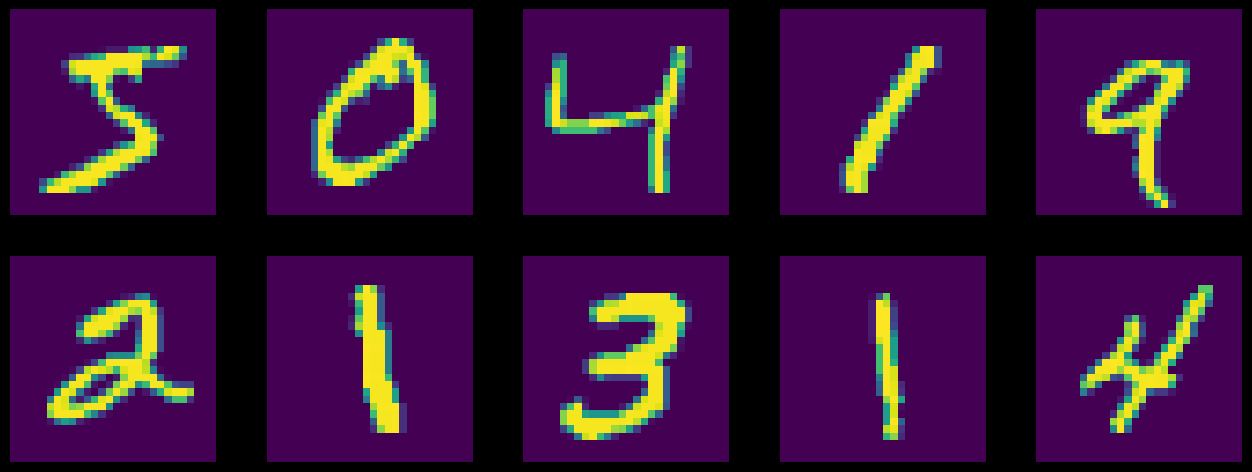

In [4]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

### Create the model classes
For comparison purposes we will create two models classes: 
1. Multi-layer Perceptron
2. Convolutional Neural Network

Pay special attention to the order of the layer while creating CNNs. 

In [5]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
'''
Model Structure: 
   Input => Conv1 => ReLU => MaxPool(24 x 24 x n)
         => Conv2 => ReLU => MaxPool(12 x 12 x n)
         => Flatten(2D->1D) => FC1 => ReLU => FC2 => LogSoftmax
'''

class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50) # Fully connected neural network layer
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x) # Will it make a difference if we apply the non-linearity after the pooling layer?
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4) # this is where are flattening the 2D feature maps into a single 1D vector so as to be used by the subsequent fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [6]:
'''
Model Structure: 
   Input => Conv1 => ReLU => MaxPool(24 x 24 x n)
         => Conv2 => ReLU => MaxPool(12 x 12 x n)
         => Flatten(2D->1D) => FC1 => ReLU => FC2 => LogSoftmax
'''

class CNN2(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv4 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50) # Fully connected neural network layer
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x) # Will it make a difference if we apply the non-linearity after the pooling layer?
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4) # this is where are flattening the 2D feature maps into a single 1D vector so as to be used by the subsequent fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

#### Note
- ReLU is interchangable with the pooling function

### Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [7]:
accuracy_list = []
def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data to device, where the "device" is either a GPU if it exists or a CPU
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        # forward pass through the model
        #    No need to compute gradient here
        output = model(data)
        # forward pass through the cross-entropy loss function
        loss = F.nll_loss(output, target)
        # backward pass through the cross-entropy loss function and the model
        loss.backward()
        
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # send data to device, where the "device" is either a GPU if it exists or a CPU
            data, target = data.to(device), target.to(device)

            # permute pixels
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        accuracy_list.append(accuracy)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            accuracy))

### Train a small MLP

In [8]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.320322
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.940512
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.526497
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.017169
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.670345
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.618609
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.369846
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.549049
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.496841
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.307666

Test set: Average loss: 0.3858, Accuracy: 8828/10000 (88%)



### Train a ConvNet with the same number of parameters
Play around with the hyper-parameters to understand their relationship with model performance. 

In [9]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.331675
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.132707
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.337143
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.597874
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.313487
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.241136
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.150763
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.388028
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.333686
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.093264

Test set: Average loss: 0.1768, Accuracy: 9479/10000 (95%)



In [10]:
# # Training settings 2
# n_features = 6  # number of feature maps

# model_cnn2 = CNN2(input_size, n_features, output_size)
# model_cnn2.to(device)
# optimizer = optim.SGD(model_cnn2.parameters(), lr=0.01, momentum=0.5)
# print('Number of parameters: {}'.format(get_n_params(model_cnn2)))

# for epoch in range(0, 1):
#     train(epoch, model_cnn2)
#     test(model_cnn2)

TypeError: super(type, obj): obj must be an instance or subtype of type

### ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

### What happens if the assumptions are no longer true?
Let us break the assumption of locality and permute the pixel within each image using an arbitrary permutation matrix. Also display the permuted images. 

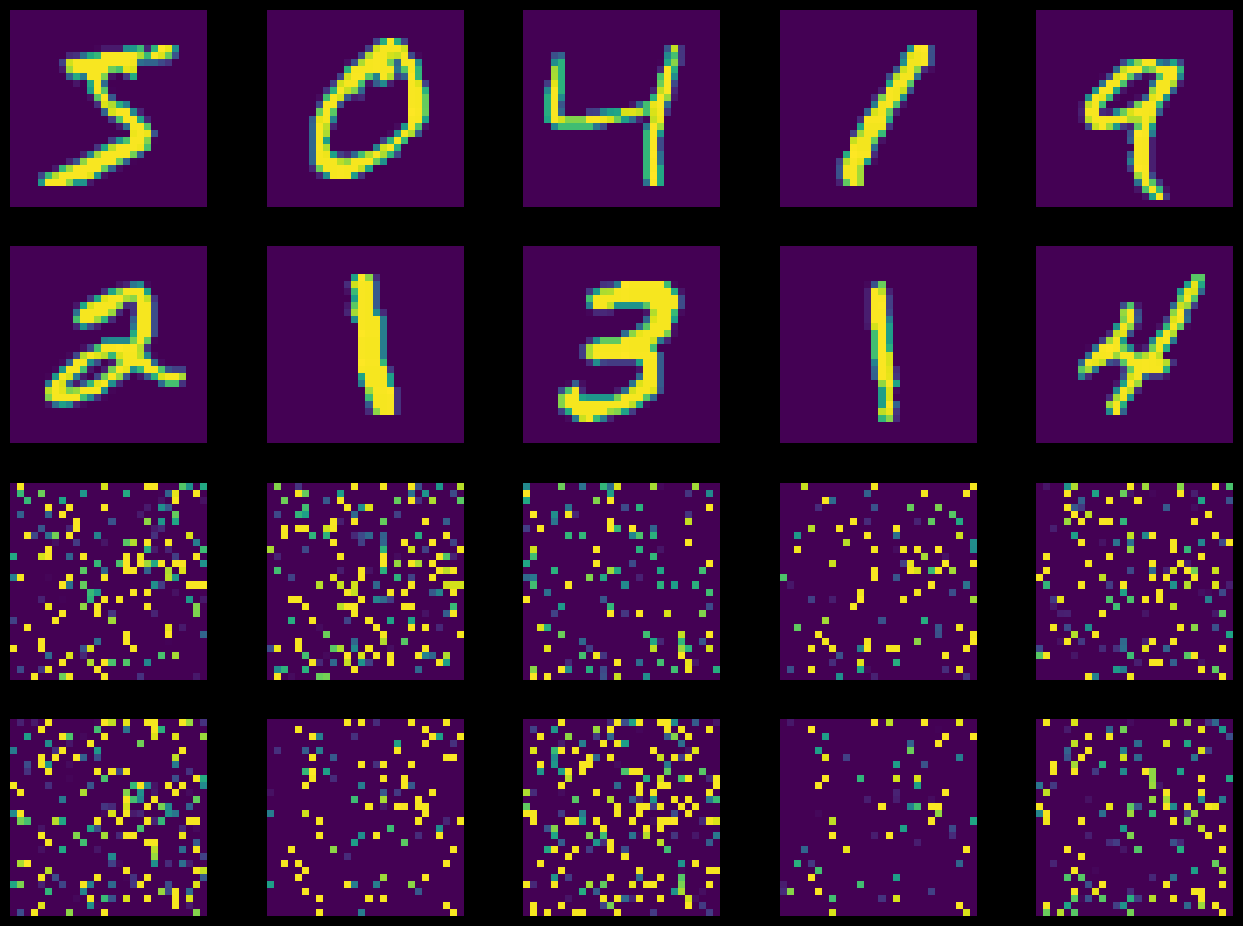

In [11]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

### CNNs with permuted pixels
What do you think will happen to CNNs when given permuted pixels as inputs? 

In [12]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.292278
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.269147
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.116971
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.717482
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.283430
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.021350
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.566342
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.536613
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.695239
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.626126

Test set: Average loss: 0.5204, Accuracy: 8399/10000 (84%)



### MLPs with permuted pixels

In [13]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.320322
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.899439
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.472129
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.200358
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.062045
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.304729
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.582018
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.661665
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.558800
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.339903

Test set: Average loss: 0.4348, Accuracy: 8781/10000 (88%)



### The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

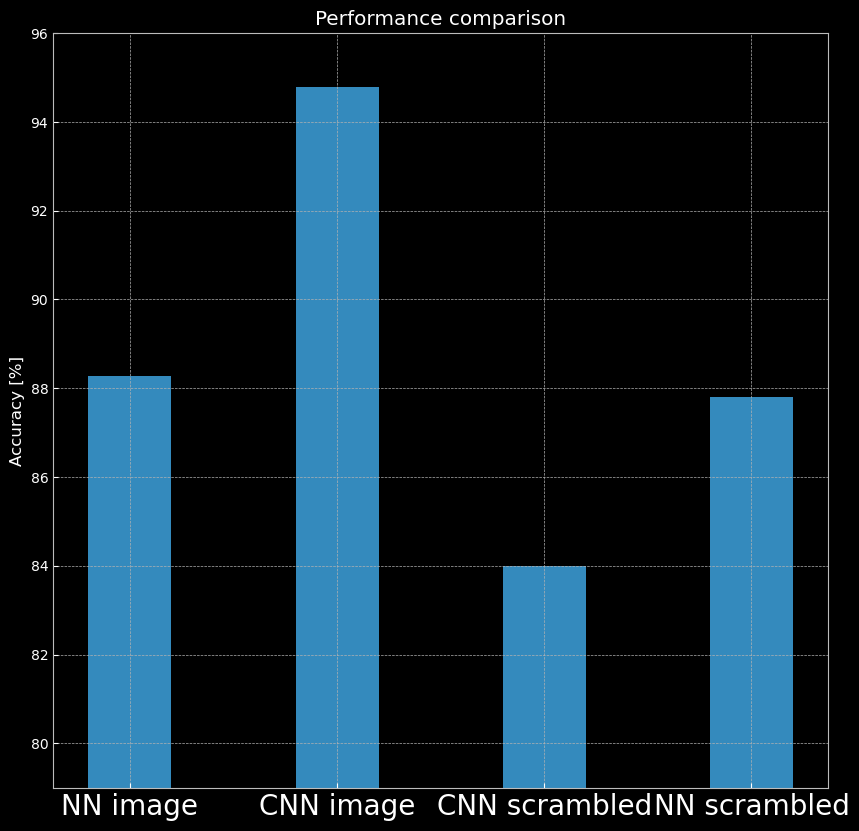

In [14]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');

### Checking Model Parameters

In [15]:
print(model_cnn)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [16]:
print(model_fnn)

FC2Layer(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


# Part 2: Recurrent Neural Networks (RNNs)
We now build a recurrent neural network and train it on a synthetic and simple sequence level task. 

### An example of many-to-one (sequence classification)

This task is taken from Experiment 6(a) in the paper [Hochreiter & Schmidhuber (1997)](www.bioinf.jku.at/publications/older/2604.pdf).

The goal is to classify sequences.
Elements and targets are represented locally (input vectors with only one non-zero bit).
The sequence starts with an `B`, ends with a `E` (the “trigger symbol”), and otherwise consists of randomly chosen symbols from the set `{a, b, c, d}` except for two elements at positions `t1` and `t2` that are either `X` or `Y`.
For the `DifficultyLevel.HARD` case, the sequence length is randomly chosen between `100` and `110`, `t1` is randomly chosen between `10` and `20`, and `t2` is randomly chosen between `50` and `60`.
There are `4` sequence classes `Q`, `R`, `S`, and `U`, which depend on the temporal order of `X` and `Y`.

The rules are:

```
X, X -> Q,
X, Y -> R,
Y, X -> S,
Y, Y -> U.
```

### Dataset Exploration

In [17]:
# Module that generates the sequence data according to the above described experiment
from sequential_tasks import TemporalOrderExp6aSequence as QRSU

In [18]:
# Create a data generator
example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=16,
)
example_batch = example_generator[1]

In [19]:
# Display the generated sequences and the labels in the current batch
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print('The sequences generated and their corresponding labels in the batch are:')
for i in range(example_batch[0].shape[0]):
    input = example_batch[0][i]
    output = example_batch[1][i]
    sequence = example_generator.decode_x(input)
    label = example_generator.decode_y(output)
    print(sequence, ' ----- ', label)

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (16, 9, 8).
The second item in the tuple is the corresponding batch of class labels with shape (16, 4).
The sequences generated and their corresponding labels in the batch are:
BbXcXcbE  -----  Q
BYdadYE  -----  U
BXddbXcE  -----  Q
BXacYdE  -----  R
BbYbXdbE  -----  S
BXbcYaE  -----  R
BXcbYacE  -----  R
BXbbaYdE  -----  R
BbXaXaE  -----  Q
BaYcYaE  -----  U
BXbddYE  -----  R
BXbbXdcE  -----  Q
BcXdYcE  -----  R
BbYbYaE  -----  U
BXcbaYcE  -----  R
BYdddYdE  -----  U


### Define the Model

In [30]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True).to(self.device)
        self.linear = torch.nn.Linear(hidden_size, output_size).to(self.device)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True).to(self.device)
        self.linear = torch.nn.Linear(hidden_size, output_size).to(self.device)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x

    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

### Define the Training Loop

In [21]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx in range(len(train_data_gen)):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)

        loss = criterion(output, target)

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()

        # the backward pass over the loss and the model
        loss.backward()

        # the gradient step to update the weights
        optimizer.step()

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

### Define the Testing Loop

In [22]:
def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

### Putting it All Together

In [23]:
import matplotlib.pyplot as plt
from plot_lib import set_default, plot_state, print_colourbar

In [24]:
set_default()

In [25]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

### Train Elman RNNs for 10 epochs

[Epoch 1/10] loss: 1.4213, acc: 24.29% - test_loss: 1.3710, test_acc: 31.35%
[Epoch 2/10] loss: 1.3603, acc: 30.75% - test_loss: 1.3846, test_acc: 37.50%
[Epoch 3/10] loss: 1.3673, acc: 40.22% - test_loss: 1.3910, test_acc: 40.12%
[Epoch 4/10] loss: 1.3636, acc: 39.82% - test_loss: 1.3435, test_acc: 43.85%
[Epoch 5/10] loss: 1.2752, acc: 44.35% - test_loss: 1.3282, test_acc: 36.59%
[Epoch 6/10] loss: 1.2631, acc: 40.22% - test_loss: 1.2412, test_acc: 41.03%
[Epoch 7/10] loss: 1.2340, acc: 44.35% - test_loss: 1.2670, test_acc: 47.58%
[Epoch 8/10] loss: 1.1193, acc: 50.40% - test_loss: 1.2446, test_acc: 48.69%
[Epoch 9/10] loss: 1.2194, acc: 48.89% - test_loss: 1.1098, test_acc: 50.81%
[Epoch 10/10] loss: 1.0805, acc: 48.69% - test_loss: 1.0649, test_acc: 52.72%


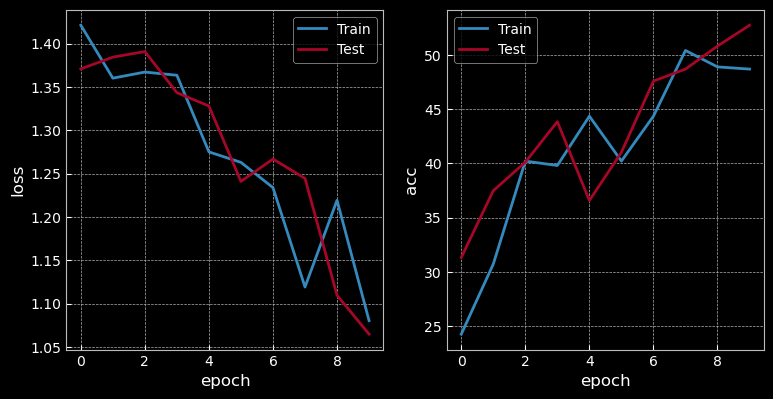

In [28]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

### Train LSTMs for 10 epochs

[Epoch 1/10] loss: 1.3718, acc: 25.10% - test_loss: 1.4314, test_acc: 23.49%
[Epoch 2/10] loss: 1.4077, acc: 26.92% - test_loss: 1.3899, test_acc: 23.99%
[Epoch 3/10] loss: 1.3850, acc: 21.37% - test_loss: 1.3571, test_acc: 23.89%
[Epoch 4/10] loss: 1.3427, acc: 26.61% - test_loss: 1.3738, test_acc: 25.81%
[Epoch 5/10] loss: 1.3228, acc: 24.29% - test_loss: 1.3426, test_acc: 31.85%
[Epoch 6/10] loss: 1.3141, acc: 42.04% - test_loss: 1.2911, test_acc: 32.46%
[Epoch 7/10] loss: 1.2829, acc: 38.10% - test_loss: 1.3027, test_acc: 36.29%
[Epoch 8/10] loss: 1.2284, acc: 34.88% - test_loss: 1.2759, test_acc: 28.63%
[Epoch 9/10] loss: 1.2118, acc: 62.80% - test_loss: 1.1529, test_acc: 86.19%
[Epoch 10/10] loss: 1.1659, acc: 79.54% - test_loss: 1.1017, test_acc: 81.15%


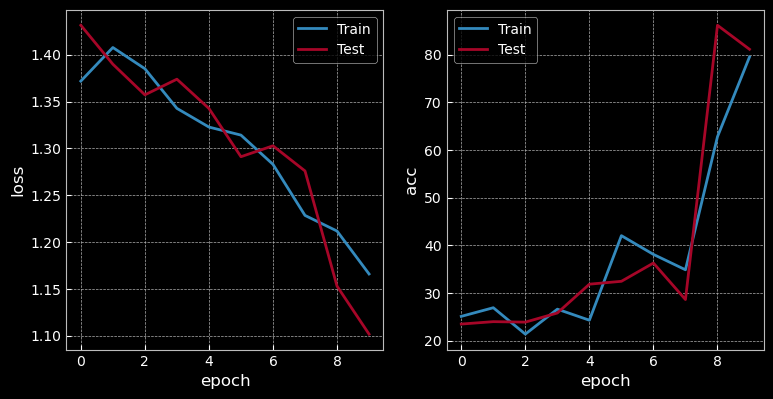

In [31]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

### Elman: Increasing epoch to 50

[Epoch 1/50] loss: 1.3334, acc: 25.30% - test_loss: 1.4625, test_acc: 25.10%
[Epoch 2/50] loss: 1.3894, acc: 26.71% - test_loss: 1.4219, test_acc: 27.12%
[Epoch 3/50] loss: 1.3881, acc: 28.63% - test_loss: 1.3868, test_acc: 37.00%
[Epoch 4/50] loss: 1.3468, acc: 32.06% - test_loss: 1.3754, test_acc: 33.27%
[Epoch 5/50] loss: 1.3699, acc: 28.83% - test_loss: 1.3478, test_acc: 35.28%
[Epoch 6/50] loss: 1.3328, acc: 35.28% - test_loss: 1.3443, test_acc: 33.06%
[Epoch 7/50] loss: 1.2801, acc: 31.75% - test_loss: 1.2581, test_acc: 34.07%
[Epoch 8/50] loss: 1.2858, acc: 33.06% - test_loss: 1.1785, test_acc: 38.71%
[Epoch 9/50] loss: 1.1892, acc: 37.30% - test_loss: 1.1025, test_acc: 45.77%
[Epoch 10/50] loss: 1.1222, acc: 48.08% - test_loss: 1.0349, test_acc: 48.08%
[Epoch 11/50] loss: 1.0909, acc: 49.29% - test_loss: 0.9858, test_acc: 49.80%
[Epoch 12/50] loss: 0.9129, acc: 49.19% - test_loss: 1.0162, test_acc: 47.48%
[Epoch 13/50] loss: 1.0025, acc: 52.12% - test_loss: 0.8812, test_acc: 50

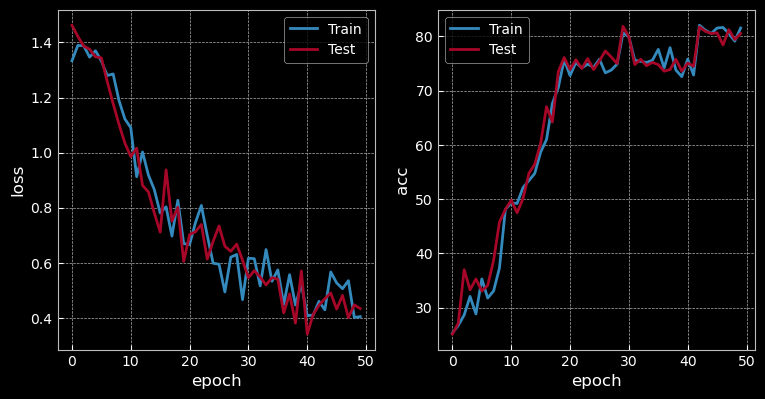

In [32]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 50

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True)

### LSTMs: Increasing epoch to 50

[Epoch 1/50] loss: 1.3875, acc: 24.40% - test_loss: 1.4190, test_acc: 25.81%
[Epoch 2/50] loss: 1.3913, acc: 23.99% - test_loss: 1.3812, test_acc: 21.77%
[Epoch 3/50] loss: 1.3812, acc: 24.60% - test_loss: 1.3868, test_acc: 24.80%
[Epoch 4/50] loss: 1.3813, acc: 25.60% - test_loss: 1.3913, test_acc: 26.61%
[Epoch 5/50] loss: 1.3836, acc: 26.11% - test_loss: 1.3834, test_acc: 25.40%
[Epoch 6/50] loss: 1.3860, acc: 22.78% - test_loss: 1.3894, test_acc: 25.10%
[Epoch 7/50] loss: 1.3843, acc: 27.22% - test_loss: 1.3852, test_acc: 26.71%
[Epoch 8/50] loss: 1.3871, acc: 25.71% - test_loss: 1.3877, test_acc: 25.50%
[Epoch 9/50] loss: 1.3948, acc: 25.20% - test_loss: 1.3823, test_acc: 25.50%
[Epoch 10/50] loss: 1.3875, acc: 27.82% - test_loss: 1.3700, test_acc: 25.60%
[Epoch 11/50] loss: 1.3851, acc: 23.69% - test_loss: 1.3865, test_acc: 26.11%
[Epoch 12/50] loss: 1.3778, acc: 25.91% - test_loss: 1.3727, test_acc: 27.22%
[Epoch 13/50] loss: 1.3818, acc: 25.50% - test_loss: 1.3936, test_acc: 26

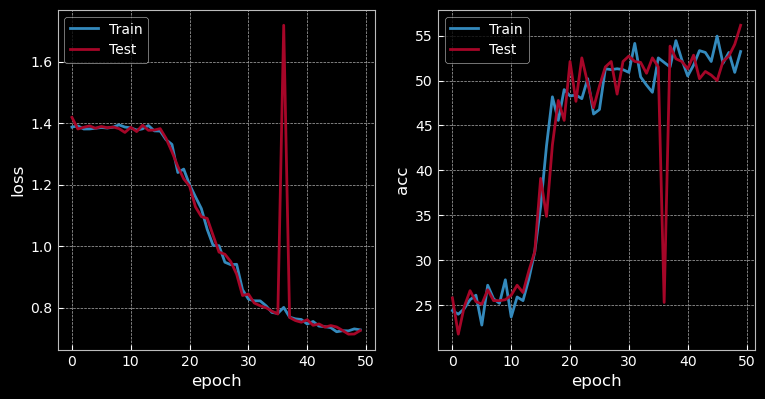

In [44]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.NORMAL
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 50

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True)

### Model Evaluation

In [40]:
import collections
import random

def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Define a dictionary that maps class indices to labels
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator
    data_generator = QRSU.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears
    count_classes = collections.Counter()

    # Keep correctly classified and misclassified sequences, and their
    # true and predicted class labels, for diagnostic information.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.cpu().numpy())
            target_decoded = data_generator.decode_y_batch(
                target.cpu().numpy())

            output = model(data)
            sequence_end = torch.tensor([len(sequence) for sequence in data_decoded]) - 1
            output = output[torch.arange(data.shape[0]).long(), sequence_end, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))

    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')

    # Report the accuracy by class
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')

    # Report some random sequences for examination
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)]
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\nThere were no misclassified sequences.')

In [41]:
evaluate_model(model, difficulty)

The accuracy of the model is measured to be 53.12%.

Q: 273 / 273 correct
R: 40 / 234 correct
S: 72 / 259 correct
U: 142 / 226 correct

Here are some example sequences:
BacbaYcaccbaccbabdcdaXbcdbdabbaadccE -> S was labelled S
BdYcabbbdcdcabcaadaabbcddXddbbbcbacbbbE -> S was labelled S
BbcbaXbabccbadaabdabaaacbcXdbbbccbE -> Q was labelled Q
BaddbYdaaadbbdcacadaaaddaYacacaacccE -> U was labelled U
BddYdbbaccdddbabbdcccdcdXaccbaddbdbdE -> S was labelled S
BdYcabbbdcdcabcaadaabbcddXddbbbcbacbbbE -> S was labelled S
BadYbcadbacbabcabaabdcYdddcaacaaaE -> U was labelled U
BacbaYcaccbaccbabdcdaXbcdbdabbaadccE -> S was labelled S
BddYdbbaccdddbabbdcccdcdXaccbaddbdbdE -> S was labelled S
BaddbYdaaadbbdcacadaaaddaYacacaacccE -> U was labelled U

There were no misclassified sequences.
